# Simple geography

In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xroms
#%matplotlib notebook
%matplotlib inline

### Using the model grid projection

The model grid is an orthogonal map projection. Often quite non-standard, like in our 
case here.

A coastline in lon, lat can be generated from `GSHHS` by the correct `basemap` set-up.
The script `make_coast.py` does the job and save the result as an `.npy`-file.
Using the `ll2xy` method, makes a coast line in the grid projection. It can be useful
to save this as a `.npy` file to speed up generation of grid maps.

A simple way to put the grid on a map, is to add contour lines of longitude and 
latitude.

In [2]:
# Initiate the Dataset
A = xroms.roms_dataset("ocean_avg_0014.nc")


# Find geographic extent
print('Longitude range: {:6.2f}, {:6.2f}'.format(
      A.lon_rho.min().item(), A.lon_rho.max().item()))
print('Latitude range : {:6.2f}, {:6.2f}'.format(
      A.lat_rho.min().item(), A.lat_rho.max().item()))


Longitude range: -20.19,  15.38
Latitude range :  48.00,  65.97


Generate the coast line, both in geographical and grid coordinates.
This processing takes some time, so it it skipped if the coast files
`coast.npy`, `coast_xy.npy` already exists in the present directory.

In [3]:
import os.path

coastfile = 'coast.npy'

if not os.path.isfile('coast.npy'):

    # Generate coast line
    from make_coast import makecoast
    # from lonlat import *

    # Determine geographical extent
    # Use slightly larger extent
    lon0, lon1 = -21, 18  # Longitude range
    lat0, lat1 = 47, 67  # Latitude range

    # Choose GSHHS resolution
    GSHHSres = 'i'   # intermediate resolution

    # Choose a list of GSHHS types
    GSHHStypes = [1]  # land-sea boundary


    # Make the coast line
    makecoast(lon0, lon1, lat0, lat1, GSHHSres, GSHHStypes, coastfile)

    # Test plot
    for p in np.load(coastfile):
        plt.plot(*p)
    

In [4]:
# Make the grid coast file if needed.
if not os.path.isfile('coast_xy.npy'):
    
    from lonlat import ll2xy1
    
    # Read and convert to grid coordinates
    xcoast, ycoast = [], []
    xy = []
    for p in np.load(coastfile):
        px, py = ll2xy1(A, *p)
        xy.append((px, py))

    # Save the coastline in grid coordinates
    np.save('coast_xy.npy', xy)

    # Test plot
    for p in xy:
        plt.plot(*p)

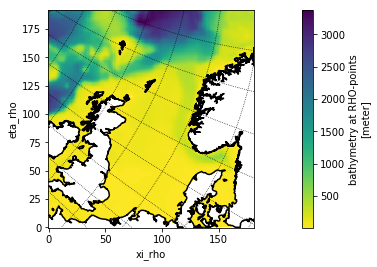

In [5]:
# Read bottom topography
H = A.h.where(A.mask_rho > 0)

# levels for longitude/latitude lines
lons = np.arange(-20, 20, 5)
lats = np.arange(48, 66, 2)

# Coast line
coast_polygons = np.load("coast_xy.npy")

# Make the plot
plt.figure() 
H.plot(cmap='viridis_r')
A.lon_rho.plot.contour(levels=lons, colors='black', linewidths=0.7, linestyles=':')
A.lat_rho.plot.contour(levels=lats, colors='black', linewidths=0.7, linestyles=':')
for p in coast_polygons:
    plt.plot(*p, color='black')
plt.axis('image');

### Regrid to longitude, latitude grid

The resolution in the model file,  `0.001/A.pm.mean()`,  is approximately 8 km.
Focus on the Skagerrak, 56° to 60°N and 6° to 12°E. The resolution is finer,
4′= (1/15)° E-W and 2′ = (1/30)° N-S, both approximately 3.7 km 

In [6]:
# Denne virker ikke når A har fått geografiske koord
# Navnene lon, lat er "oppbrukt"

from lonlat import *

# Define the grid
lon0, lon1, dlon = 6, 12, 8    # 4 min = 1/15 deg, approx. 3.7 km
nlon = (lon1 - lon0)*dlon + 1
lon = np.linspace(lon0, lon1, nlon)

lat0, lat1, dlat = 56, 60, 16   # 2 min = 1/30 deg, 
nlat = (lat1-lat0)*dlat + 1
lat = np.linspace(lat0, lat1, nlat)

# Make the 2D grid
lon2, lat2 = np.meshgrid(lon, lat)
# The grid points in the model grid
x2, y2 = ll2xy1(A, lon2, lat2)

# Make DataArrays 
coords = dict(latitude=lat, longitude=lon)
x2 = xr.DataArray(x2, dims=coords.keys(), coords=coords)
y2 = xr.DataArray(y2, dims=coords.keys(), coords=coords)

# The regridded Dataset
B = A.interp(xi_rho=x2, eta_rho=y2)

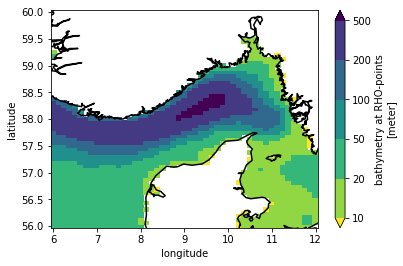

In [7]:
HB = B.h.where(B.mask_rho > 0.5)
levels = [10, 20, 50, 100, 200, 500]
coast_pols = np.load('coast.npy')

plt.figure()
HB.plot(levels=levels, cmap='viridis_r')
for p in coast_pols:
    plt.plot(*p, color='black')

Take a horizontal slice at 50 meter of the fourth timestamp.
and plot in grid coordinates versus longitude/latitude.

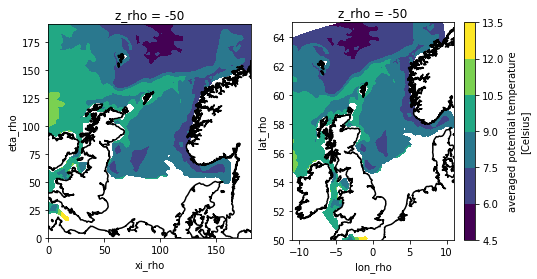

In [8]:
# Select time = 3 and take a slice at 50 meter
depth = 50
temp50 = xroms.zslice(A.temp.isel(time=3), depth)

# kan få denne notasjonen q
#temp50 = A.temp.isel(time=3).xroms.zslice(depth)

# Plot
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

# Grid coordinates
temp50.plot.contourf(ax=axes[0], add_colorbar=False)
xy_pols = np.load('coast_xy.npy')
for p in xy_pols:
    axes[0].plot(*p, color='black')
axes[0].axis('image')

# Geographical coordinates
temp50.plot.contourf('lon_rho', 'lat_rho', ax=axes[1])
for p in coast_pols:
    axes[1].plot(*p, color='black')
axes[1].axis([-11, 11, 50, 65]);